Back to **[Fan](https://fanwangecon.github.io/)**'s R4Econ Homepage **[Table of Content](https://fanwangecon.github.io/R4Econ/)**

# Fraction of Variation Explained by Right Hand Side Regression Terms

One runs a number of regressions. With different outcomes, and various right hand side variables. 

What is the remaining variation in the left hand side variable if right hand side variable one by one is set to the average of the observed values. 

Dependency: C:\Users\fan\R4Econ\linreg\ivreg\ivregdfrow.R

The code below does not work with categorical variables (except for dummies).

Dummy variable inputs need to be converted to zero/one first.

## Program

In [151]:
ff_lr_decompose <- function(df, vars.y, vars.x, vars.c, vars.z, vars.other.keep,
                            list.vars.tomean, list.vars.tomean.name.suffix,
                            graph=FALSE, graph.nrow=2) {

    vars.xc <- c(vars.x, vars.c)

    # Regressions
    # regf.iv from C:\Users\fan\R4Econ\linreg\ivreg\ivregdfrow.R
    df.reg.out <- as_tibble(bind_rows(lapply(vars.y, regf.iv,
                                             vars.x=vars.x, vars.c=vars.c, vars.z=vars.z, df=df)))

    # Select Variables
    str.esti.suffix <- '_Estimate'
    arr.esti.name <- paste0(vars.xc, str.esti.suffix)
    str.outcome.name <- 'vars_var.y'
    arr.columns2select <- c(arr.esti.name, str.outcome.name)
    # arr.columns2select

    # Generate dataframe for coefficients
    df.coef <- df.reg.out[,c(arr.columns2select)] %>% mutate_at(vars(arr.esti.name), as.numeric) %>% column_to_rownames(str.outcome.name)
    # df.coef
    # str(df.coef)

    # Decomposition Step 1: gather
    df.decompose <- df %>%
                            filter(svymthRound %in% c(12, 18, 24)) %>%
                            select(one_of(c(vars.other.keep, vars.xc, vars.y))) %>%
                            drop_na() %>%
                            gather(variable, value, -one_of(c(vars.other.keep, vars.xc)))

    # Decomposition Step 2: mutate_at(vars, funs(mean = mean(.)))
    # the xc averaging could have taken place earlier, no difference in mean across variables
    df.decompose <- df.decompose %>%
                          group_by(variable) %>%
                          mutate_at(vars(c(vars.xc, 'value')), funs(mean = mean(.))) %>%
                          ungroup()

    # Decomposition Step 3 With Loop
    for (i in 1:length(list.vars.tomean)) {
        var.decomp.cur <- (paste0('value', list.vars.tomean.name.suffix[[i]]))
        vars.tomean <- list.vars.tomean[[i]]
        var.decomp.cur
        df.decompose <- df.decompose %>% mutate((!!var.decomp.cur) := ff_lr_decompose_valadj(., df.coef, vars.tomean, str.esti.suffix))
    }

    # Additional Statistics
    df.decompose.var.frac <- df.decompose %>%
            select(variable, contains('value')) %>%
            group_by(variable) %>%
            summarize_all(funs(mean = mean, var = var)) %>%
            select(matches('value')) %>% select(ends_with("_var")) %>%
            mutate_if(is.numeric, funs( frac = (./value_var))) %>%
            mutate_if(is.numeric, round, 3)

    # Graph
    g.graph.dist <- NULL
    if (graph) {
      g.graph.dist <- df.decompose %>%
          select(variable, contains('value'), -value_mean) %>%
          rename(outcome = variable) %>%
          gather(variable, value, -outcome) %>%
          ggplot(aes(x=value, color = variable, fill = variable)) +
              geom_line(stat = "density") +
              facet_wrap(~ outcome, scales='free', nrow=graph.nrow)
    }

    # Return
    return(list(dfmain = df.decompose,
                dfsumm = df.decompose.var.frac,
                graph = g.graph.dist))

}

# Support Function
ff_lr_decompose_valadj <- function(df, df.coef, vars.tomean, str.esti.suffix) {
    new_value <- (df$value +
                  rowSums((df[paste0(vars.tomean, '_mean')] - df[vars.tomean])
                          *df.coef[df$variable, paste0(vars.tomean, str.esti.suffix)]))
    return(new_value)
}

## Load Data

In [152]:
# Library
library(tidyverse)
library(AER)

# Load Sample Data
setwd('C:/Users/fan/R4Econ/_data/')
df <- read_csv('height_weight.csv')

# Source Dependency
source('C:/Users/fan/R4Econ/linreg/ivreg/ivregdfrow.R')

# Setting
options(repr.matrix.max.rows=50, repr.matrix.max.cols=50)

Parsed with column specification:
cols(
  S.country = col_character(),
  vil.id = col_double(),
  indi.id = col_double(),
  sex = col_character(),
  svymthRound = col_double(),
  momEdu = col_double(),
  wealthIdx = col_double(),
  hgt = col_double(),
  wgt = col_double(),
  hgt0 = col_double(),
  wgt0 = col_double(),
  prot = col_double(),
  cal = col_double(),
  p.A.prot = col_double(),
  p.A.nProt = col_double()
)


## Data Cleaning

In [153]:
# Convert Variable for Sex which is categorical to Numeric
df <- df
df$male <- (as.numeric(factor(df$sex)) - 1)
summary(factor(df$sex))
summary(df$male)

Female   Male 
 16446  18619

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   0.000   1.000   0.531   1.000   1.000 

## Parameters

In [154]:
var.y1 <- c('hgt')
var.y2 <- c('wgt')
vars.y <- c(var.y1, var.y2)
vars.x <- c('prot')
vars.c <- c('male', 'wgt0', 'hgt0', 'svymthRound')
vars.other.keep <- c('S.country', 'vil.id', 'indi.id', 'svymthRound')

# Decompose sequence
vars.tomean.first <- c('male', 'hgt0')
var.tomean.first.name.suffix <- '_A'
vars.tomean.third <- c(vars.tomean.second, 'prot')
var.tomean.third.name.suffix <- '_B'
vars.tomean.fourth <- c(vars.tomean.third, 'svymthRound')
var.tomean.fourth.name.suffix <- '_C'
list.vars.tomean = list(vars.tomean.first, 
                        vars.tomean.third,
                        vars.tomean.fourth)
list.vars.tomean.name.suffix <- list(var.tomean.first.name.suffix, 
                                     var.tomean.third.name.suffix,
                                     var.tomean.fourth.name.suffix)

## Example Guatemala OLS

In [155]:
df.use <- df %>% filter(S.country == 'Guatemala') %>% filter(svymthRound %in% c(12, 18, 24))
vars.z <- NULL
list.out <- ff_lr_decompose(df=df.use, vars.y, vars.x, vars.c, vars.z, vars.other.keep,
                            list.vars.tomean, list.vars.tomean.name.suffix,
                            graph=TRUE, graph.nrow=1)
options(repr.matrix.max.rows=10, repr.matrix.max.cols=50)
list.out$dfmain
options(repr.plot.width = 10, repr.plot.height = 4)
list.out$dfsumm

Warning message:
"Setting row names on a tibble is deprecated."

S.country,vil.id,indi.id,svymthRound,prot,male,wgt0,hgt0,variable,value,prot_mean,male_mean,wgt0_mean,hgt0_mean,svymthRound_mean,value_mean,value_A,value_B,value_C
Guatemala,3,1352,18,13.3,1,2545.2,47.4,hgt,70.2,20.64819,0.5499276,3312.297,49.75137,18.42547,73.41216,71.37891,73.31571,73.60235
Guatemala,3,1352,24,46.3,1,2545.2,47.4,hgt,75.8,20.64819,0.5499276,3312.297,49.75137,18.42547,73.41216,76.97891,77.44455,73.68902
Guatemala,3,1354,12,1.0,1,3634.3,51.2,hgt,66.3,20.64819,0.5499276,3312.297,49.75137,18.42547,73.41216,65.24416,65.17313,69.50194
Guatemala,3,1354,18,9.8,1,3634.3,51.2,hgt,69.2,20.64819,0.5499276,3312.297,49.75137,18.42547,73.41216,68.14416,67.68082,67.96746
Guatemala,3,1354,24,15.4,1,3634.3,51.2,hgt,75.3,20.64819,0.5499276,3312.297,49.75137,18.42547,73.41216,74.24416,73.53117,69.77564
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Guatemala,14,2019,12,17.3,1,3132.9,49.7,wgt,7777.6,20.64819,0.5499276,3312.297,49.75137,18.42547,8807.877,7702.788,7861.861,8639.751
Guatemala,14,2019,18,24.5,1,3132.9,49.7,wgt,9729.6,20.64819,0.5499276,3312.297,49.75137,18.42547,8807.877,9654.788,9667.175,9718.684
Guatemala,14,2019,24,57.8,1,3132.9,49.7,wgt,10276.5,20.64819,0.5499276,3312.297,49.75137,18.42547,8807.877,10201.688,9535.651,8860.779
Guatemala,14,2023,12,15.9,1,3607.1,50.3,wgt,8424.7,20.64819,0.5499276,3312.297,49.75137,18.42547,8807.877,8304.458,8216.735,8994.625


value_var,value_mean_var,value_A_var,value_B_var,value_C_var,value_var_frac,value_mean_var_frac,value_A_var_frac,value_B_var_frac,value_C_var_frac
21.864,NA,20.264,21.231,10.293,1,NA,0.927,0.971,0.471
2965693.245,NA,2863501.267,2662604.945,2316612.760,1,NA,0.966,0.898,0.781


## Example Guatemala IV = vil.id

Warning message:
"Setting row names on a tibble is deprecated."

value_var,value_mean_var,value_A_var,value_B_var,value_C_var,value_var_frac,value_mean_var_frac,value_A_var_frac,value_B_var_frac,value_C_var_frac
21.864,NA,20.235,18.623,11.653,1,NA,0.926,0.852,0.533
2965693.245,NA,2876682.895,2663130.427,2555834.238,1,NA,0.970,0.898,0.862


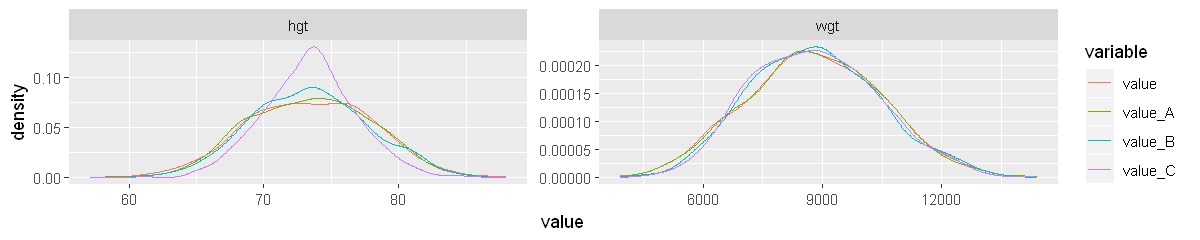

In [156]:
df.use <- df %>% filter(S.country == 'Guatemala') %>% filter(svymthRound %in% c(12, 18, 24))
vars.z <- c('vil.id')
list.out <- ff_lr_decompose(df=df.use, vars.y, vars.x, vars.c, vars.z, vars.other.keep,
                            list.vars.tomean, list.vars.tomean.name.suffix,
                            graph=TRUE, graph.nrow=1)
list.out$dfsumm
options(repr.plot.width = 10, repr.plot.height = 2)
list.out$graph

## Example Cebu OLS

In [157]:
df.use <- df %>% filter(S.country == 'Cebu') %>% filter(svymthRound %in% c(12, 18, 24))
vars.z <- NULL
list.out <- ff_lr_decompose(df=df.use, vars.y, vars.x, vars.c, vars.z, vars.other.keep,
                            list.vars.tomean, list.vars.tomean.name.suffix,
                            graph=TRUE, graph.nrow=1)
options(repr.matrix.max.rows=10, repr.matrix.max.cols=50)
list.out$dfmain
options(repr.plot.width = 10, repr.plot.height = 4)
list.out$dfsumm

Warning message:
"Setting row names on a tibble is deprecated."

S.country,vil.id,indi.id,svymthRound,prot,male,wgt0,hgt0,variable,value,prot_mean,male_mean,wgt0_mean,hgt0_mean,svymthRound_mean,value_mean,value_A,value_B,value_C
Cebu,1,1,12,11.3,1,2043.8,44.2,hgt,70.8,16.95957,0.5263013,2988.773,49.23897,17.87441,74.99584,72.12171,75.23858,79.26306
Cebu,1,2,12,5.9,0,2839.9,49.7,hgt,72.2,16.95957,0.5263013,2988.773,49.23897,17.87441,74.99584,72.64812,73.04655,77.07104
Cebu,1,2,18,0.5,0,2839.9,49.7,hgt,76.5,16.95957,0.5263013,2988.773,49.23897,17.87441,74.99584,76.94812,77.54600,77.45996
Cebu,1,2,24,14.1,0,2839.9,49.7,hgt,79.2,16.95957,0.5263013,2988.773,49.23897,17.87441,74.99584,79.64812,79.74370,75.54714
Cebu,1,3,12,21.4,0,3445.6,51.7,hgt,68.0,16.95957,0.5263013,2988.773,49.23897,17.87441,74.99584,67.70200,66.12292,70.14740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Cebu,33,1348,18,48.6,1,3339.5,52.4,wgt,9938.4,16.95957,0.5263013,2988.773,49.23897,17.87441,8845.333,9632.231,8705.546,8687.786
Cebu,33,1348,24,17.6,1,3339.5,52.4,wgt,13120.4,16.95957,0.5263013,2988.773,49.23897,17.87441,8845.333,12814.231,12439.011,11572.732
Cebu,33,1349,12,15.3,1,3216.5,50.9,wgt,8979.3,16.95957,0.5263013,2988.773,49.23897,17.87441,8845.333,8700.920,8501.461,9332.220
Cebu,33,1349,18,12.0,1,3216.5,50.9,wgt,10759.6,16.95957,0.5263013,2988.773,49.23897,17.87441,8845.333,10481.220,10340.466,10322.705


value_var,value_mean_var,value_A_var,value_B_var,value_C_var,value_var_frac,value_mean_var_frac,value_A_var_frac,value_B_var_frac,value_C_var_frac
24.375,NA,22.561,21.712,10.423,1,NA,0.926,0.891,0.428
3337460.957,NA,3218987.397,2898062.395,2417504.727,1,NA,0.965,0.868,0.724


## Example Cebu IV

Warning message:
"Setting row names on a tibble is deprecated."

value_var,value_mean_var,value_A_var,value_B_var,value_C_var,value_var_frac,value_mean_var_frac,value_A_var_frac,value_B_var_frac,value_C_var_frac
24.375,NA,22.625,22.676,14.89,1,NA,0.928,0.930,0.611
3337460.957,NA,3237415.252,3298020.911,3071065.97,1,NA,0.970,0.988,0.920


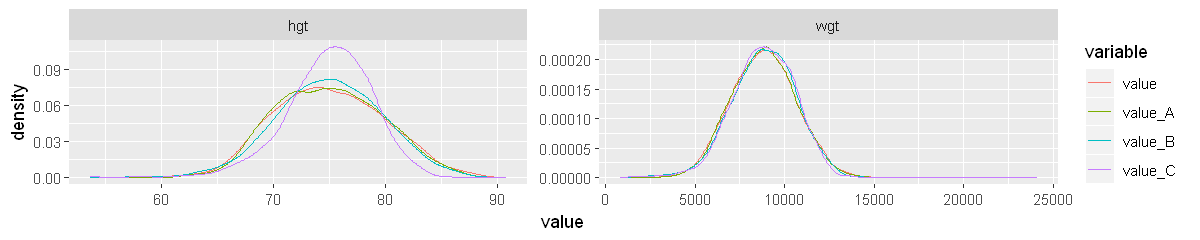

In [158]:
df.use <- df %>% filter(S.country == 'Cebu') %>% filter(svymthRound %in% c(12, 18, 24))
vars.z <- c('wealthIdx')
list.out <- ff_lr_decompose(df=df.use, vars.y, vars.x, vars.c, vars.z, vars.other.keep,
                            list.vars.tomean, list.vars.tomean.name.suffix,
                            graph=TRUE, graph.nrow=1)
list.out$dfsumm
options(repr.plot.width = 10, repr.plot.height = 2)
list.out$graph

## Examples Line by Line

The examples are just to test the code with different types of variables.

In [159]:
df.use <- df %>% filter(S.country == 'Guatemala') %>% filter(svymthRound %in% c(12, 18, 24))
dim(df.use)

[1] 2022   16

### Setting Up Parameters

In [160]:
# Define Left Hand Side Variables
var.y1 <- c('hgt')
var.y2 <- c('wgt')
vars.y <- c(var.y1, var.y2)
# Define Right Hand Side Variables
vars.x <- c('prot')
vars.c <- c('male', 'wgt0', 'hgt0', 'svymthRound')
# vars.z <- c('p.A.prot')
vars.z <- c('vil.id')
# vars.z <- NULL
vars.xc <- c(vars.x, vars.c)

# Other variables to keep
vars.other.keep <- c('S.country', 'vil.id', 'indi.id', 'svymthRound')

# Decompose sequence
vars.tomean.first <- c('male', 'hgt0')
var.tomean.first.name.suffix <- '_mh02m'
vars.tomean.second <- c(vars.tomean.first, 'hgt0', 'wgt0')
var.tomean.second.name.suffix <- '_mh0me2m'
vars.tomean.third <- c(vars.tomean.second, 'prot')
var.tomean.third.name.suffix <- '_mh0mep2m'
vars.tomean.fourth <- c(vars.tomean.third, 'svymthRound')
var.tomean.fourth.name.suffix <- '_mh0mepm2m'
list.vars.tomean = list(
#                         vars.tomean.first, 
                        vars.tomean.second,                         
                        vars.tomean.third,
                        vars.tomean.fourth
                        )
list.vars.tomean.name.suffix <- list(
#                                     var.tomean.first.name.suffix, 
                                     var.tomean.second.name.suffix,
                                     var.tomean.third.name.suffix,
                                     var.tomean.fourth.name.suffix
                                    )

### Obtain Regression Coefficients from somewhere

In [161]:
# Regressions
# regf.iv from C:\Users\fan\R4Econ\linreg\ivreg\ivregdfrow.R
df.reg.out <- as_tibble(bind_rows(lapply(vars.y, regf.iv,
                                         vars.x=vars.x, vars.c=vars.c, vars.z=vars.z, df=df)))
# Regressions
# reg1 <- regf.iv(var.y = var.y1, vars.x, vars.c, vars.z, df.use)
# reg2 <- regf.iv(var.y = var.y2, vars.x, vars.c, vars.z, df.use)
# df.reg.out <- as_tibble(bind_rows(reg1, reg2))

In [162]:
options(repr.matrix.max.rows=50, repr.matrix.max.cols=50)
df.reg.out

X.Intercept._Estimate,X.Intercept._Pr...z..,X.Intercept._Std.Error,X.Intercept._zvalue,hgt0_Estimate,hgt0_Pr...z..,hgt0_Std.Error,hgt0_zvalue,male_Estimate,male_Pr...z..,male_Std.Error,male_zvalue,prot_Estimate,prot_Pr...z..,prot_Std.Error,prot_zvalue,Sargan_df1,svymthRound_Estimate,svymthRound_Pr...z..,svymthRound_Std.Error,svymthRound_zvalue,vars_var.y,vars_vars.c,vars_vars.x,vars_vars.z,Weakinstruments_df1,Weakinstruments_df2,Weakinstruments_p.value,Weakinstruments_statistic,wgt0_Estimate,wgt0_Pr...z..,wgt0_Std.Error,wgt0_zvalue,Wu.Hausman_df1,Wu.Hausman_df2,Wu.Hausman_p.value,Wu.Hausman_statistic
22.2547168993562,8.90880805116339e-75,1.21637209166939,18.2959778934199,0.683485333749857,4.55758747404583e-123,0.0289699490334337,23.5929077044995,1.24473528437265,6.90641190023989e-47,0.0865599892152535,14.3800304928101,-0.27147719759472,1.41850396300123e-19,0.0299946394681993,-9.05085716674618,0,1.13391864772583,0,0.0250995291586825,45.176889198082,hgt,male+wgt0+hgt0+svymthRound,prot,vil.id,1,18957,2.50701851391303e-60,270.337017802049,0.000443041849600911,0.00335642643992964,0.00015105124195408,2.93305664931638,1,18956,2.71953708467901e-42,186.64752853014
-1101.09005806864,0.00510620293260513,393.210441213089,-2.80025640893889,75.4867896610275,3.00433623813613e-16,9.23594523428083,8.17315258440956,489.852902350196,3.81065764666863e-65,28.7388865413848,17.0449506331706,-59.0727542411542,9.53469044018094e-09,10.293563528696,-5.73880503835948,0,250.778883169332,6.33178366808817e-190,8.53129752452757,29.395163215014,wgt,male+wgt0+hgt0+svymthRound,prot,vil.id,1,18962,1.34647368544412e-60,271.592883001643,0.769615810959556,1.88093171544694e-60,0.0469249111255955,16.4010073220952,1,18961,4.84720137482191e-16,65.9737961330202


In [163]:
# Select Variables
str.esti.suffix <- '_Estimate'
arr.esti.name <- paste0(vars.xc, str.esti.suffix)
str.outcome.name <- 'vars_var.y'
arr.columns2select <- c(arr.esti.name, str.outcome.name)
arr.columns2select

[1] "prot_Estimate"        "male_Estimate"        "wgt0_Estimate"       
[4] "hgt0_Estimate"        "svymthRound_Estimate" "vars_var.y"

In [164]:
# Generate dataframe for coefficients
df.coef <- df.reg.out[,c(arr.columns2select)] %>% mutate_at(vars(arr.esti.name), as.numeric) %>% column_to_rownames(str.outcome.name) 
df.coef
str(df.coef)

Warning message:
"Setting row names on a tibble is deprecated."

,prot_Estimate,male_Estimate,wgt0_Estimate,hgt0_Estimate,svymthRound_Estimate
hgt,-0.2714772,1.244735,0.0004430418,0.6834853,1.133919
wgt,-59.0727542,489.852902,0.7696158110,75.4867897,250.778883


Classes 'tbl_df', 'tbl' and 'data.frame':	2 obs. of  5 variables:
 $ prot_Estimate       : num  -0.271 -59.073
 $ male_Estimate       : num  1.24 489.85
 $ wgt0_Estimate       : num  0.000443 0.769616
 $ hgt0_Estimate       : num  0.683 75.487
 $ svymthRound_Estimate: num  1.13 250.78


### Decomposition Step 1

In [165]:
# Decomposition Step 1: gather
df.decompose_step1 <- df.use %>% 
                        filter(svymthRound %in% c(12, 18, 24)) %>%
                        select(one_of(c(vars.other.keep, vars.xc, vars.y))) %>% 
                        drop_na() %>% 
                        gather(variable, value, -one_of(c(vars.other.keep, vars.xc)))
options(repr.matrix.max.rows=20, repr.matrix.max.cols=20)
dim(df.decompose_step1)
df.decompose_step1

[1] 1382   10

S.country,vil.id,indi.id,svymthRound,prot,male,wgt0,hgt0,variable,value
Guatemala,3,1352,18,13.3,1,2545.2,47.4,hgt,70.2
Guatemala,3,1352,24,46.3,1,2545.2,47.4,hgt,75.8
Guatemala,3,1354,12,1.0,1,3634.3,51.2,hgt,66.3
Guatemala,3,1354,18,9.8,1,3634.3,51.2,hgt,69.2
Guatemala,3,1354,24,15.4,1,3634.3,51.2,hgt,75.3
Guatemala,3,1356,12,8.6,1,3911.8,51.9,hgt,68.1
Guatemala,3,1356,18,17.8,1,3911.8,51.9,hgt,74.1
Guatemala,3,1356,24,30.5,1,3911.8,51.9,hgt,77.1
Guatemala,3,1357,12,1.0,1,3791.4,52.6,hgt,71.5
Guatemala,3,1357,18,12.7,1,3791.4,52.6,hgt,77.8


### Decomposition Step 2

In [166]:
# Decomposition Step 2: mutate_at(vars, funs(mean = mean(.)))
# the xc averaging could have taken place earlier, no difference in mean across variables
df.decompose_step2 <- df.decompose_step1 %>% 
                        group_by(variable) %>% 
                        mutate_at(vars(c(vars.xc, 'value')), funs(mean = mean(.))) %>% 
                        ungroup()

options(repr.matrix.max.rows=20, repr.matrix.max.cols=20)
dim(df.decompose_step2)
df.decompose_step2

[1] 1382   16

S.country,vil.id,indi.id,svymthRound,prot,male,wgt0,hgt0,variable,value,prot_mean,male_mean,wgt0_mean,hgt0_mean,svymthRound_mean,value_mean
Guatemala,3,1352,18,13.3,1,2545.2,47.4,hgt,70.2,20.64819,0.5499276,3312.297,49.75137,18.42547,73.41216
Guatemala,3,1352,24,46.3,1,2545.2,47.4,hgt,75.8,20.64819,0.5499276,3312.297,49.75137,18.42547,73.41216
Guatemala,3,1354,12,1.0,1,3634.3,51.2,hgt,66.3,20.64819,0.5499276,3312.297,49.75137,18.42547,73.41216
Guatemala,3,1354,18,9.8,1,3634.3,51.2,hgt,69.2,20.64819,0.5499276,3312.297,49.75137,18.42547,73.41216
Guatemala,3,1354,24,15.4,1,3634.3,51.2,hgt,75.3,20.64819,0.5499276,3312.297,49.75137,18.42547,73.41216
Guatemala,3,1356,12,8.6,1,3911.8,51.9,hgt,68.1,20.64819,0.5499276,3312.297,49.75137,18.42547,73.41216
Guatemala,3,1356,18,17.8,1,3911.8,51.9,hgt,74.1,20.64819,0.5499276,3312.297,49.75137,18.42547,73.41216
Guatemala,3,1356,24,30.5,1,3911.8,51.9,hgt,77.1,20.64819,0.5499276,3312.297,49.75137,18.42547,73.41216
Guatemala,3,1357,12,1.0,1,3791.4,52.6,hgt,71.5,20.64819,0.5499276,3312.297,49.75137,18.42547,73.41216
Guatemala,3,1357,18,12.7,1,3791.4,52.6,hgt,77.8,20.64819,0.5499276,3312.297,49.75137,18.42547,73.41216


### Decomposition Step 3 Non-Loop

In [167]:
ff_lr_decompose_valadj <- function(df, df.coef, vars.tomean, str.esti.suffix) {    
    new_value <- (df$value + 
                  rowSums((df[paste0(vars.tomean, '_mean')] - df[vars.tomean])
                          *df.coef[df$variable, paste0(vars.tomean, str.esti.suffix)]))    
    return(new_value)
}

# # Decomposition Step 3: mutate_at(vars, funs(mean = mean(.)))
# var.decomp.one <- (paste0('value', list.vars.tomean.name.suffix[[1]]))
# var.decomp.two <- (paste0('value', list.vars.tomean.name.suffix[[2]]))
# var.decomp.thr <- (paste0('value', list.vars.tomean.name.suffix[[3]]))
# df.decompose_step3 <- df.decompose_step2 %>% 
#                         mutate((!!var.decomp.one) := f_decompose_here(., df.coef, list.vars.tomean[[1]], str.esti.suffix), 
#                                (!!var.decomp.two) := f_decompose_here(., df.coef, list.vars.tomean[[2]], str.esti.suffix),
#                                (!!var.decomp.thr) := f_decompose_here(., df.coef, list.vars.tomean[[3]], str.esti.suffix))

# options(repr.matrix.max.rows=10, repr.matrix.max.cols=20)
# dim(df.decompose_step3)
# df.decompose_step3

### Decomposition Step 3 With Loop

In [168]:
df.decompose_step3 <- df.decompose_step2
for (i in 1:length(list.vars.tomean)) {
    var.decomp.cur <- (paste0('value', list.vars.tomean.name.suffix[[i]]))
    vars.tomean <- list.vars.tomean[[i]]
    var.decomp.cur
    df.decompose_step3 <- df.decompose_step3 %>% mutate((!!var.decomp.cur) := ff_lr_decompose_valadj(., df.coef, vars.tomean, str.esti.suffix))
    
}
options(repr.matrix.max.rows=10, repr.matrix.max.cols=20)
dim(df.decompose_step3)
df.decompose_step3

[1] 1382   19

S.country,vil.id,indi.id,svymthRound,prot,male,wgt0,hgt0,variable,value,prot_mean,male_mean,wgt0_mean,hgt0_mean,svymthRound_mean,value_mean,value_mh0me2m,value_mh0mep2m,value_mh0mepm2m
Guatemala,3,1352,18,13.3,1,2545.2,47.4,hgt,70.2,20.64819,0.5499276,3312.297,49.75137,18.42547,73.41216,73.19390,71.19903,71.68148
Guatemala,3,1352,24,46.3,1,2545.2,47.4,hgt,75.8,20.64819,0.5499276,3312.297,49.75137,18.42547,73.41216,78.79390,85.75778,79.43671
Guatemala,3,1354,12,1.0,1,3634.3,51.2,hgt,66.3,20.64819,0.5499276,3312.297,49.75137,18.42547,73.41216,63.61689,58.28285,65.56882
Guatemala,3,1354,18,9.8,1,3634.3,51.2,hgt,69.2,20.64819,0.5499276,3312.297,49.75137,18.42547,73.41216,66.51689,63.57185,64.05430
Guatemala,3,1354,24,15.4,1,3634.3,51.2,hgt,75.3,20.64819,0.5499276,3312.297,49.75137,18.42547,73.41216,72.61689,71.19213,64.87106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Guatemala,14,2019,12,17.3,1,3132.9,49.7,wgt,7777.6,20.64819,0.5499276,3312.297,49.75137,18.42547,8807.877,7702.954,7505.167,9116.539
Guatemala,14,2019,18,24.5,1,3132.9,49.7,wgt,9729.6,20.64819,0.5499276,3312.297,49.75137,18.42547,8807.877,9654.954,9882.491,9989.190
Guatemala,14,2019,24,57.8,1,3132.9,49.7,wgt,10276.5,20.64819,0.5499276,3312.297,49.75137,18.42547,8807.877,10201.854,12396.514,10998.539
Guatemala,14,2023,12,15.9,1,3607.1,50.3,wgt,8424.7,20.64819,0.5499276,3312.297,49.75137,18.42547,8807.877,7894.518,7614.029,9225.402


### Decomposition Step 4 Variance

In [169]:
df.decompose_step3 %>%
        select(variable, contains('value')) %>%
        group_by(variable) %>%
        summarize_all(funs(mean = mean, var = var)) %>%
        select(matches('value')) %>% select(ends_with("_var")) %>%
        mutate_if(is.numeric, funs( frac = (./value_var))) %>%
        mutate_if(is.numeric, round, 3)            

value_var,value_mean_var,value_mh0me2m_var,value_mh0mep2m_var,value_mh0mepm2m_var,value_var_frac,value_mean_var_frac,value_mh0me2m_var_frac,value_mh0mep2m_var_frac,value_mh0mepm2m_var_frac
21.864,NA,25.35,49.047,23.06,1,NA,1.159,2.243,1.055
2965693.245,NA,2949187.64,4192769.518,3147506.60,1,NA,0.994,1.414,1.061


### Graphical Results

Graphically, difficult to pick up exact differences in variance, a 50 percent reduction in variance visually does not look like 50 percent. Intuitively, we are kind of seeing standard deviation, not variance on the graph if we think abou the x-scale. 

In [170]:
df.decompose_step3 %>% 
    select(variable, contains('value'), -value_mean)

variable,value,value_mh0me2m,value_mh0mep2m,value_mh0mepm2m
hgt,70.2,73.19390,71.19903,71.68148
hgt,75.8,78.79390,85.75778,79.43671
hgt,66.3,63.61689,58.28285,65.56882
hgt,69.2,66.51689,63.57185,64.05430
hgt,75.3,72.61689,71.19213,64.87106
...,...,...,...,...
wgt,7777.6,7702.954,7505.167,9116.539
wgt,9729.6,9654.954,9882.491,9989.190
wgt,10276.5,10201.854,12396.514,10998.539
wgt,8424.7,7894.518,7614.029,9225.402


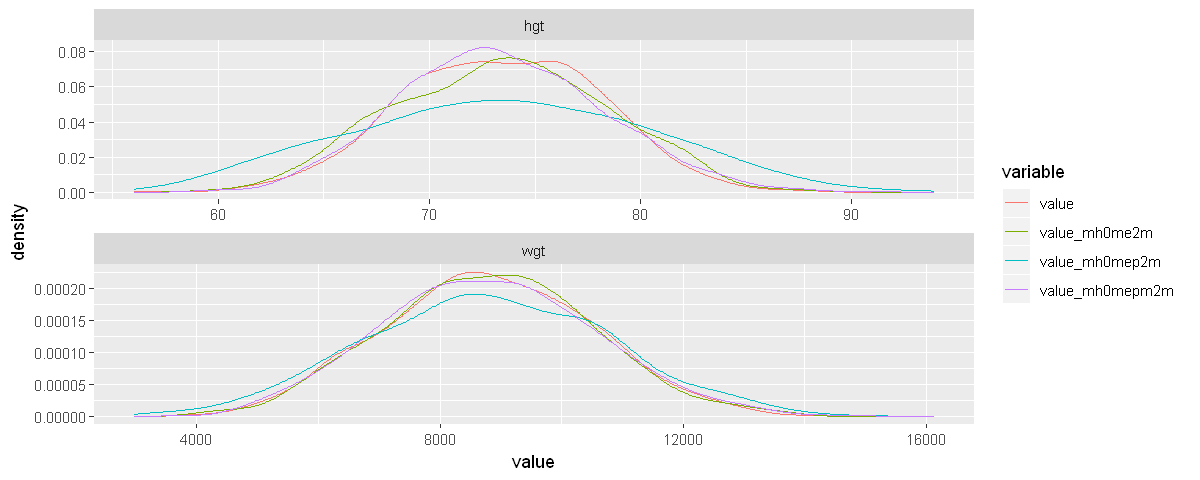

In [171]:
options(repr.plot.width = 10, repr.plot.height = 4)
df.decompose_step3 %>% 
    select(variable, contains('value'), -value_mean) %>%
    rename(outcome = variable) %>%
    gather(variable, value, -outcome) %>%
    ggplot(aes(x=value, color = variable, fill = variable)) + 
        geom_line(stat = "density") + 
        facet_wrap(~ outcome, scales='free', nrow=2)                    

### Additional Detailed Testings

In [172]:
head(df.decompose_step2[vars.tomean.first],3)
head(df.decompose_step2[paste0(vars.tomean.first, '_mean')], 3)
head(df.coef[df.decompose_step2$variable, paste0(vars.tomean.first, str.esti.suffix)], 3)
df.decompose.tomean.first <- df.decompose_step2 %>%
    mutate(pred_new = df.decompose_step2$value +
        rowSums((df.decompose_step2[paste0(vars.tomean.first, '_mean')] - df.decompose_step2[vars.tomean.first])
            *df.coef[df.decompose_step2$variable, paste0(vars.tomean.first, str.esti.suffix)])) %>%
        select(variable, value, pred_new)
head(df.decompose.tomean.first, 10)
df.decompose.tomean.first %>%
        group_by(variable) %>%
        summarize_all(funs(mean = mean, sd = sd))

male,hgt0
1,47.4
1,47.4
1,51.2


male_mean,hgt0_mean
0.5499276,49.75137
0.5499276,49.75137
0.5499276,49.75137


male_Estimate,hgt0_Estimate
1.244735,0.6834853
1.244735,0.6834853
1.244735,0.6834853


variable,value,pred_new
hgt,70.2,71.24691
hgt,75.8,76.84691
hgt,66.3,64.74966
hgt,69.2,67.64966
hgt,75.3,73.74966
hgt,68.1,66.07123
hgt,74.1,72.07123
hgt,77.1,75.07123
hgt,71.5,68.99279
hgt,77.8,75.29279


variable,value_mean,pred_new_mean,value_sd,pred_new_sd
hgt,73.41216,73.41216,4.675867,4.534947
wgt,8807.87656,8807.87656,1722.118824,1695.221845


Note the r-square from regression above matches up with the 1 - ratio below. This is the proper decomposition method that is equivalent to r2. 

In [173]:
df.decompose_step2 %>%
    mutate(pred_new = df.decompose_step2$value +
        rowSums((df.decompose_step2[paste0(vars.tomean.second, '_mean')] - df.decompose_step2[vars.tomean.second])
            *df.coef[df.decompose_step2$variable, paste0(vars.tomean.second, str.esti.suffix)])) %>%
        select(variable, value, pred_new) %>%
        group_by(variable) %>%
        summarize_all(funs(mean = mean, var = var)) %>%
        mutate(ratio = (pred_new_var/value_var))

variable,value_mean,pred_new_mean,value_var,pred_new_var,ratio
hgt,73.41216,73.41216,2.186374e+01,25.3504,1.1594724
wgt,8807.87656,8807.87656,2.965693e+06,2949187.6357,0.9944345
